# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load in our data
filepath = '../../Data/entitiesResolved/merged_data_final.csv'
data = pd.read_csv(filepath)

## Features to try:

Recall that the EDA done revealed that we should try to use the following features:

1. TOI/GP
2. XGF/60 - and possibly combining it with SCF/60, FF/60, HDCF/60, CF/60, SF/60, and MDCF/60 to create a new feature.
3. GF/60
4. TOTAL ASSISTS/60 - But possibly using FIRST ASSISTS/60 and SECOND_ASSISTS/60 instead.
5. GOALS/60
6. Handedness

In [27]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

In [5]:
# Assuming your pipeline is named 'pipeline' and has been fitted

# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# # Print the sorted feature importances
# for feature, importance in sorted_importances:
#     print(f"{feature}: {importance}")

# If you have a large number of features and only want to see the top ones, you can slice the list
print("Top 10 most important features:")
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance}")


Top 10 most important features:
FF/GP: 0.1398696005344391
CF/GP: 0.12551434338092804
OFF. ZONE FACEOFFS/GP: 0.11292216926813126
TOI/GP: 0.0664486289024353
SCF/GP: 0.03036690130829811
XGF/GP: 0.027693569660186768
HITS TAKEN/60: 0.012604819610714912
SHOTS/GP: 0.010218915529549122
TOTAL POINTS/GP: 0.009481308981776237
DEF. ZONE FACEOFFS/GP: 0.009205847978591919


In [6]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [7]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [8]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
1012,alex ovechkin,2009-10,"$9,538,462.00","$9,136,650.00","$-401,812.00",0.160857
2984,alex ovechkin,2012-13,"$9,538,462.00","$9,159,274.00","$-379,188.00",0.152655
10586,connor mcdavid,2021-22,"$12,500,000.00","$12,352,475.00","$-147,525.00",0.151564
43,brad richards,2007-08,"$7,800,000.00","$7,530,813.00","$-269,187.00",0.149718
9726,connor mcdavid,2020-21,"$12,500,000.00","$12,153,331.00","$-346,669.00",0.149121
1544,sidney crosby,2009-10,"$8,700,000.00","$8,341,721.00","$-358,279.00",0.146861
12694,nathan mackinnon,2023-24,"$12,600,000.00","$12,105,639.00","$-494,361.00",0.144978
12324,connor mcdavid,2023-24,"$12,500,000.00","$12,023,203.00","$-476,797.00",0.143990
11478,connor mcdavid,2022-23,"$12,500,000.00","$11,860,699.00","$-639,301.00",0.143766
2197,sidney crosby,2010-11,"$8,700,000.00","$8,485,591.00","$-214,409.00",0.142855


In [9]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
5584,connor mcdavid,2015-16,"$3,775,000.00","$3,455,568.00","$-319,432.00",0.048397
6433,connor mcdavid,2016-17,"$3,775,000.00","$2,086,913.00","$-1,688,087.00",0.028588
7257,connor mcdavid,2017-18,"$3,775,000.00","$1,528,239.00","$-2,246,761.00",0.020377
8089,connor mcdavid,2018-19,"$12,500,000.00","$11,100,641.00","$-1,399,359.00",0.139631
8923,connor mcdavid,2019-20,"$12,500,000.00","$11,347,049.00","$-1,152,951.00",0.139228
9726,connor mcdavid,2020-21,"$12,500,000.00","$12,153,331.00","$-346,669.00",0.149121
10586,connor mcdavid,2021-22,"$12,500,000.00","$12,352,475.00","$-147,525.00",0.151564
11478,connor mcdavid,2022-23,"$12,500,000.00","$11,860,699.00","$-639,301.00",0.143766
12324,connor mcdavid,2023-24,"$12,500,000.00","$12,023,203.00","$-476,797.00",0.143990


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Forwards')

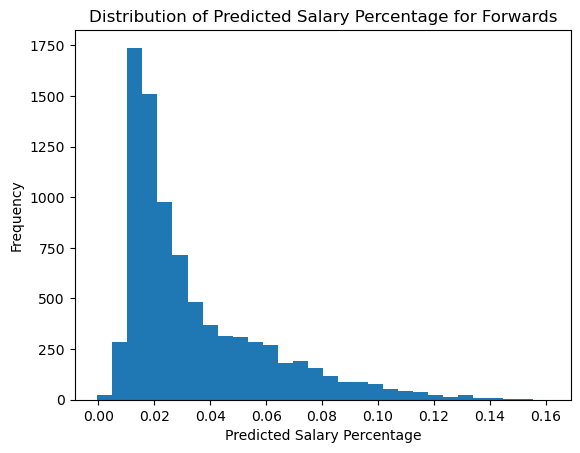

In [10]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Forwards')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Centers')

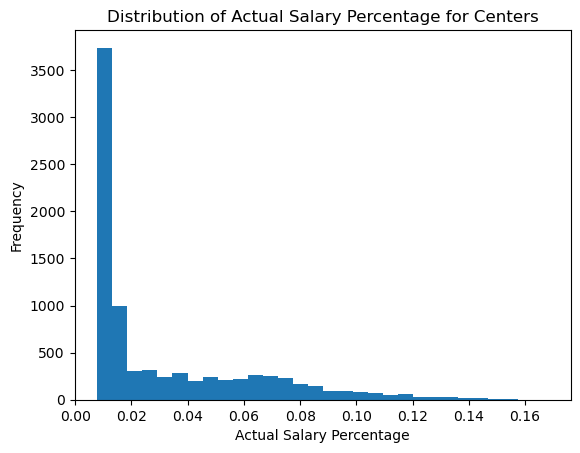

In [11]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Centers')

In [12]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12522,col,jonathan drouin,2023-24,"$825,000.00","$3,341,067.00","$2,516,067.00",0.040013,2516067.0
12615,min,marco rossi,2023-24,"$1,713,333.00","$4,161,618.00","$2,448,285.00",0.049840,2448285.0
12213,fla,anton lundell,2023-24,"$1,775,000.00","$4,001,405.00","$2,226,405.00",0.047921,2226405.0
12922,nyr,vincent trocheck,2023-24,"$5,625,000.00","$7,392,484.00","$1,767,484.00",0.088533,1767484.0
12350,n.j,dawson mercer,2023-24,"$1,294,167.00","$3,057,744.00","$1,763,577.00",0.036620,1763577.0
12805,min,ryan hartman,2023-24,"$1,700,000.00","$3,455,224.00","$1,755,224.00",0.041380,1755224.0
12937,dal,wyatt johnston,2023-24,"$1,000,417.00","$2,670,250.00","$1,669,833.00",0.031979,1669833.0
12193,nyr,alexis lafrenière,2023-24,"$2,325,000.00","$3,991,100.00","$1,666,100.00",0.047798,1666100.0
12413,nsh,gustav nyquist,2023-24,"$3,185,000.00","$4,590,874.00","$1,405,874.00",0.054981,1405874.0
12398,s.j,fabian zetterlund,2023-24,"$1,450,000.00","$2,843,599.00","$1,393,599.00",0.034055,1393599.0


In [13]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12257,mtl,brendan gallagher,2023-24,"$6,500,000.00","$5,390,126.00","$-1,109,874.00",0.064552,-1109874.0
12774,l.a,quinton byfield,2023-24,"$3,544,167.00","$2,430,032.00","$-1,114,135.00",0.029102,-1114135.0
12492,car,jesperi kotkaniemi,2023-24,"$4,820,000.00","$3,641,052.00","$-1,178,948.00",0.043605,-1178948.0
12895,ana,troy terry,2023-24,"$7,000,000.00","$5,806,381.00","$-1,193,619.00",0.069537,-1193619.0
12173,det,alex debrincat,2023-24,"$7,875,000.00","$6,669,815.00","$-1,205,185.00",0.079878,-1205185.0
12427,vgk,ivan barbashev,2023-24,"$5,000,000.00","$3,770,789.00","$-1,229,211.00",0.045159,-1229211.0
12487,pit,jeff carter,2023-24,"$3,125,000.00","$1,867,498.00","$-1,257,502.00",0.022365,-1257502.0
12685,tor,mitchell marner,2023-24,"$10,903,000.00","$9,639,353.00","$-1,263,647.00",0.115441,-1263647.0
12224,nyr,barclay goodrow,2023-24,"$3,641,667.00","$2,282,860.00","$-1,358,807.00",0.027340,-1358807.0
12798,dal,roope hintz,2023-24,"$8,450,000.00","$7,074,953.00","$-1,375,047.00",0.084730,-1375047.0


In [14]:
filtered_data[filtered_data['PLAYER'] == 'leon draisaitl'][display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
12586,leon draisaitl,2023-24,"$8,500,000.00","$8,877,891.00","$377,891.00",0.106322


In [24]:
predictions = pd.DataFrame(forwards['PRED_SALARY_PERCENTAGE'])

In [25]:
# Save predictions to disk
save_dir = '../../Data/predictions/'
filename = 'forwards_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)